In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms
import torchvision as tv

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузим датасет

На занятии мы познакомимся с датасетом Симпсонов! Там собраны знакомые многим персонажи знаменитого мультфильма для решения задачи классификации.

In [2]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

# from google.colab import drive

# drive.mount("/content/drive")

In [3]:
# !mkdir -p data

# !cp drive/MyDrive/netology_dl_sem/test.zip data/
# !cp drive/MyDrive/netology_dl_sem/train.zip data/

# !unzip -o -qq data/test.zip -d data/
# !unzip -o -qq data/train.zip -d data/
# !rm -rf data/simpsons_dataset/simpsons_dataset

Все данные теперь находятся в папке `data`.

Тестовые данные (`kaggle_simpson_testset/`) сегодня не пригодятся.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [4]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "d:/Dll/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

In [5]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# train_transform = transforms.Compose([
#     transforms.Resize(input_size),
#     transforms.CenterCrop(input_size-50),
#     transforms.ColorJitter(0.9, 0.9, 0.9),
#     transforms.RandomAffine(5),
#     transforms.RandomRotation(30),
#     transforms.ElasticTransform(alpha=150.0),
#     transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#     transforms.CenterCrop(input_size-50),
#     transforms.ToTensor(),
# ])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [6]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из `val` и `train`

In [7]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=3, ncols=4, figsize=(8, 6),
        sharey=True, sharex=True
    )

    idx = 50
    for fig_x in ax.flatten():
        #idx = np.random.randint(low=0, high=6000)
        idx +=200
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

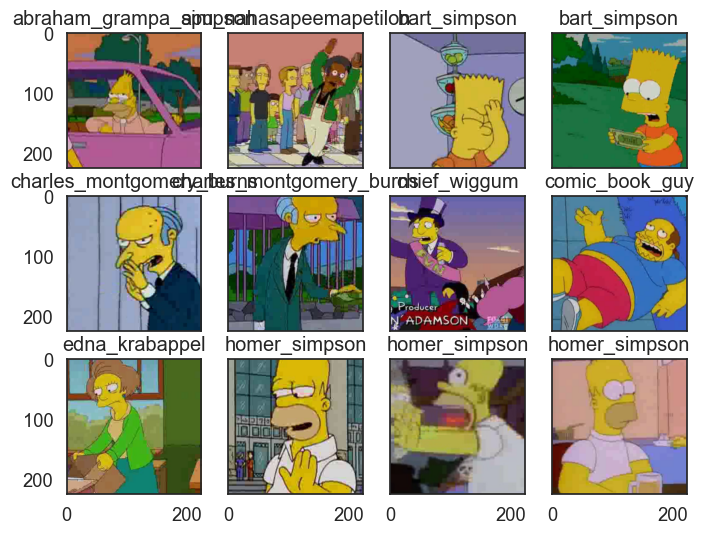

In [8]:
show_images(val_dataset)

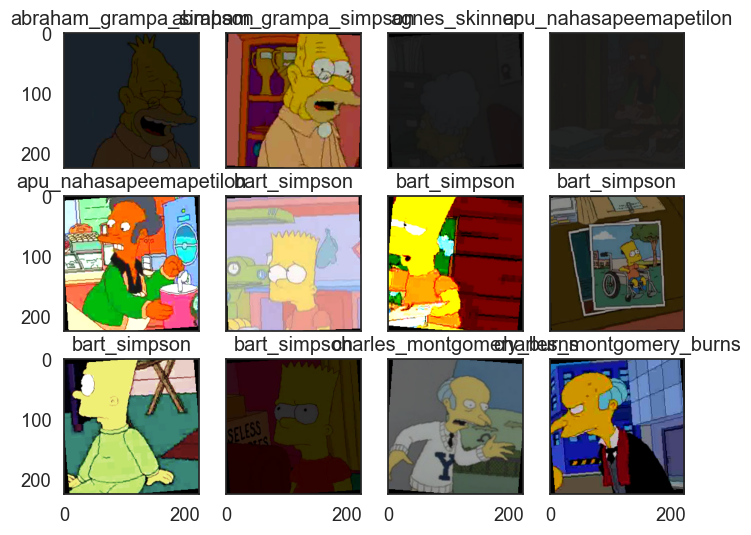

In [9]:
show_images(train_dataset)

Невооруженным взглядом видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.plot(history['lr']['train'], label='lr')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    scheduler,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            # очистить кэш
            if device == "cuda": 
                torch.cuda.empty_cache()

        
        
        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        history['lr']['train'].append(get_lr(optimizer))
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  learning rate: \t\t\t{:.4f}".format(get_lr(optimizer)))
        
        plot_learning_curves(history)
        
        scheduler.step(val_loss)
        
        # ограничить обучение при достижении заданной точности и не менее 10 эпох
        if val_acc > 0.95 and epoch >= 20:
            break
        
    return model, history

In [14]:
batch_size = 32

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [15]:
#from torchvision.models import resnet18

Обучим `Resnet18` с нуля

In [16]:
# model = resnet18(weights=False)
# model.fc = nn.Linear(512, 42)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# clf_model, history = train(
#     model, criterion, optimizer, 
#     train_batch_gen, val_batch_gen, 
#     num_epochs=10
# )

Будем использовать сеть как `Feature Extractor`

In [17]:
# # возьмём предобученную сеть
# fe_model = resnet18(weights=True)

# # заморозим все слои сети
# for param in fe_model.parameters():
#     param.requires_grad = False

# # добавим над feature extractor сетью классификационный слой
# fe_model.fc = nn.Linear(512, 42)
# fe_model = fe_model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

# clf_model, history = train(
#     fe_model, criterion, optimizer, 
#     train_batch_gen, val_batch_gen, 
#     num_epochs=10
# )

Будем использовать как `FineTuning`

In [18]:
model = tv.models.mobilenet_v3_large(weights='IMAGENET1K_V1')
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [19]:
# Убираем требование градиента:
# for param in model.parameters():
#     param.requires_grad = False
    
# model.classifier = nn.Sequential(
#     nn.Linear(in_features=960, out_features=1280, bias=True),
#     nn.Hardswish(),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1280, out_features=1000, bias=True)
#   )

# fine_tuning_model = nn.Sequential()

# #fine_tuning_model.add_module('resnet', resnet18(weights=True))
# fine_tuning_model.add_module('MobiletNet', model);

# # добавим новые слои для классификации для нашей конкретной задачи
# fine_tuning_model.add_module('relu_1', nn.ReLU())
# fine_tuning_model.add_module('mn_1', nn.Linear(1000, 512))
# fine_tuning_model.add_module('relu_2', nn.ReLU())
# fine_tuning_model.add_module('mn_2', nn.Linear(512, 42))

# print("Params to learn:")
# params_to_update = []
# for name, param in fine_tuning_model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

In [20]:

# fine_tuning_model = fine_tuning_model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

In [21]:
#print(get_lr(optimizer))

In [22]:
# # уменьшаем LR, если качество перестало улучшаться
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

# clf_model, history = train(
#     fine_tuning_model, criterion, optimizer, 
#     train_batch_gen, val_batch_gen, scheduler,
#     num_epochs=100
# )

Почему в данном случае обучение с нуля дало худший результат, а fine tuning -- наилучший?

**Документация по шедулерам**

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [23]:
# # сохранить обученную модель
# torch.save(fine_tuning_model.state_dict(), 'MobileNet_fine_tuning_model.pth')

In [24]:
# val_dataset[0][0].shape

In [30]:
model = tv.models.mobilenet_v3_large(weights='IMAGENET1K_V1')
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('MobiletNet', model);
# # добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('mn_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('mn_2', nn.Linear(512, 42))

In [31]:
fine_tuning_model.load_state_dict(torch.load('MobileNet_fine_tuning_model.pth'))

<All keys matched successfully>

In [ ]:
plt.imshow(np.transpose(val_dataset[2][0].numpy(), (1, 2, 0)))


In [ ]:
def show_image(data):
#     fig, ax = plt.subplots(
#         nrows=1, ncols=1, figsize=(8, 6),
#         sharey=True, sharex=True
#     )
    img, label = data
    print(label)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
#     for fig_x in ax.flatten():
#         #idx = np.random.randint(low=0, high=6000)
#         idx +=200
#         img, label = dataset[idx]
#         print(dataset.classes[label])
#         plt.imshow(img.numpy().transpose((1, 2, 0)))

In [ ]:
index = 0
with torch.no_grad():
    for data in val_dataset:
#         images, labels = data
        val_batch_tst = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        for X_batch, y_batch in val_batch_tst:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device) 
            break
            
        print(X_batch[0])
        outputs = fine_tuning_model(X_batch[0].to(device))
        print(outputs)
        
#         _, predicted = torch.max(outputs.data, 1)
#         img, label = data
#         print(label)
        #show_image(data)
        break